### Notebook 1: Synthetic Models - Planar Faults
extracting exhumation information from synthetic kinematic models using pynoddy (only planar faults!)

##### Import useful packages

In [7]:
import pynoddy
import importlib
importlib.reload(pynoddy)
import pynoddy.history
import pandas as pd
import pickle
import copy
from tqdm import tqdm
import numpy as np
import pynoddy.output
import sys, os
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=np.inf)

sys.path.append(os.path.abspath('../hspace'))
import hspace.measures
importlib.reload(hspace.measures)

pymc is not installed - Bayesian entropy estimation will not work.


<module 'hspace.measures' from 'C:\\Users\\Sofia\\Documents\\Sofia\\Noddy\\hspace\\hspace\\measures.py'>

In [8]:
sys.path.append(os.path.abspath('../functions'))
from exh_functions import *
from exh_processing import *

In [9]:
folder = "SyntheticModels"
output_folder = f"outputs/{folder}"
os.makedirs(output_folder, exist_ok=True)

In [12]:
#Note: for computing the noddy models, make sure that you have the noddy executable downloaded - you can find this on pynoddy's
#github page, all you need to do is clone the repository and set the path. Does not work on Mac.
noddy_path = r'C:\Users\Sofia\pynoddy\noddyapp\noddy_win64.exe'

### Planar faults model

In [10]:
model = 'planar_faults'

In [11]:
#Load the Noddy models
history = '../models/twofaults_translation.his' #this is just an example, might not be exactly like the model in the manuscript
output_name = f'{output_folder}/{model}_out'
pynoddy.compute_model(history, output_name, 
                      noddy_path = noddy_path)

hist = pynoddy.history.NoddyHistory(history)
out_hd = pynoddy.output.NoddyOutput(output_name)

#Now increase the resolution - I recommend using 100 (100 m per voxel)
hist.change_cube_size(100)
hist_hd = f'{output_folder}/{model}_hd.his'
out_hd = f'{output_folder}/{model}_out_hd'
hist.write_history(hist_hd) #overwrite the original history with the hd history
pynoddy.compute_model(hist_hd, out_hd, noddy_path = noddy_path)
out_hd = pynoddy.output.NoddyOutput(out_hd)

outputs/SyntheticModels/planar_faults_out
outputs/SyntheticModels/planar_faults_out_hd


#### Check out some model stats

In [13]:
print(out_hd.nx, out_hd.ny, out_hd.nz)
print(out_hd.extent_x, out_hd.extent_y, out_hd.extent_z)
print(out_hd.zmin, out_hd.zmax)  

104 74 50
10400.0 7400.0 5000.0
0.0 5000.0


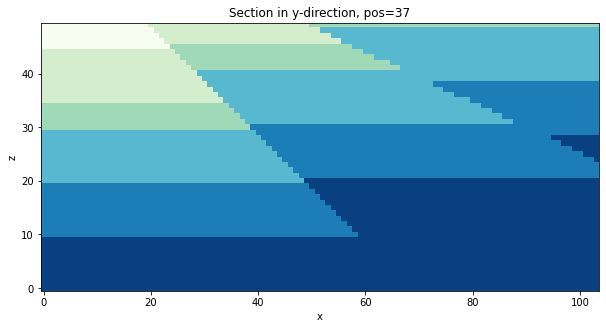

In [15]:
out_hd.plot_section('y', cmap = 'GnBu')

In [22]:
#access the events:
hist.events

{1: <pynoddy.events.Stratigraphy at 0x26480c6fca0>,
 2: <pynoddy.events.Fault at 0x26480c6f550>,
 3: <pynoddy.events.Fault at 0x2649b12e490>}

In [23]:
#access the event properties:
hist.events[2].properties

{'Geometry': 'Translation',
 'Movement': 'Hanging Wall',
 'X': 793.0,
 'Y': 0.0,
 'Z': 5000.0,
 'Dip Direction': 90.0,
 'Dip': 45.0,
 'Pitch': 90.0,
 'Slip': -1500.0,
 'Rotation': 30.0,
 'Amplitude': 2000.0,
 'Radius': 1000.0,
 'XAxis': 2000.0,
 'YAxis': 2000.0,
 'ZAxis': 2000.0,
 'Cyl Index': 0.0,
 'Profile Pitch': 90.0,
 'Color Name': 'Color 36',
 'Red': 255.0,
 'Green': 3.0,
 'Blue': 0.0}

### Randomly modify our planar faults model

outputs/SyntheticModels/planar_faults_out_tmp
outputs/SyntheticModels/planar_faults_out_tmp
outputs/SyntheticModels/planar_faults_out_tmp
outputs/SyntheticModels/planar_faults_out_tmp
outputs/SyntheticModels/planar_faults_out_tmp
outputs/SyntheticModels/planar_faults_out_tmp
outputs/SyntheticModels/planar_faults_out_tmp
outputs/SyntheticModels/planar_faults_out_tmp
outputs/SyntheticModels/planar_faults_out_tmp
outputs/SyntheticModels/planar_faults_out_tmp
outputs/SyntheticModels/planar_faults_out_tmp
outputs/SyntheticModels/planar_faults_out_tmp
outputs/SyntheticModels/planar_faults_out_tmp
outputs/SyntheticModels/planar_faults_out_tmp
outputs/SyntheticModels/planar_faults_out_tmp
outputs/SyntheticModels/planar_faults_out_tmp


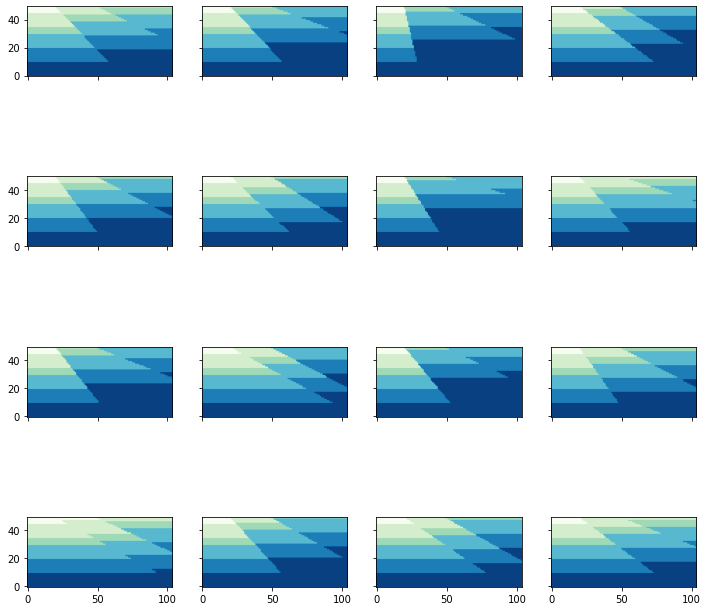

In [16]:
n_draws = 16
plot = True
modified_hist = f'{output_folder}/{model}_hist_tmp.his'
modified_out = f'{output_folder}/{model}_out_tmp'

all_blocks = np.ndarray((n_draws, out_hd.nx, out_hd.ny, out_hd.nz), dtype = 'int')

for i in range(n_draws):
    #make model virgin again
    hist_copy = copy.deepcopy(hist)
    
    #change the parameters for both faults
    for event in hist_copy.events.values():
        if isinstance(event, pynoddy.events.Fault):
            new_slip = disturb_value(event, 'Slip', 500)
            new_dip = disturb_percent(event, 'Dip', 20)
    
    #update the history and recompute the model
    hist_copy.write_history(modified_hist)
    pynoddy.compute_model(modified_hist, modified_out, noddy_path = r'C:\Users\Sofia\pynoddy\noddyapp\noddy_win64.exe')
    
    #save the outputs
    out_temp = pynoddy.output.NoddyOutput(modified_out)
    all_blocks[i,:,:,:] = out_temp.block

# now let's also plot some of the results
if plot == True:
    fig,ax = plt.subplots(n_draws//4,4, figsize = (12,12), sharey = True, sharex = True)
    for i in range(n_draws): #n_draws must be a multiple of 4. 
        ax[i//4, i%4].imshow(all_blocks[i,:,1,:].transpose(), origin = 'lower', cmap = 'GnBu')

### Now let's add some thermochron data, to constrain how much our parameters can vary

In [17]:
#create synthetic AFT data for 2-D example
samples = pd.DataFrame(columns = ['sample', 'x', 'z', 'reset'])
samples['sample'] = ['sample1', 'sample2']
samples['x'] = [45, 100]
samples['z'] = [49, 49]
samples['reset'] = [False, True] #if no, then max depth before burial = 1.3, if yes, max depth at least 2.7
samples

,sample,x,z,reset
0,sample1,45,49,False
1,sample2,100,49,True


In [18]:
#calculate initial exhumation:
#here the exhumation can be calculated using trigonometry
original_exhumation = [abs(np.sin(np.deg2rad(45)) * 1500*10), abs(np.sin(np.deg2rad(25)) *2000*10)]
original_exhumation = [original_exhumation[0], original_exhumation[0] + original_exhumation[1]]
original_params = [(2, -1500, 45), (3, -2000, 25)] #event, slip, dip

In [20]:
original_exhumation #divide by 10 to get the exhumation in meters

[10606.601717798214, 19058.9669526122]

### Define useful functions for the MCMC

In [26]:
def calc_exhumation(history): 
    
    new_hist = f'{output_folder}/{model}_new_hist.his'
    new_out = f'{output_folder}/{model}_new_out'
    
    hist_copy = copy.deepcopy(history)
    
    exhumation_list_raw = []
    exhumation_list = []
    new_params = []
    
    for i, event in enumerate(hist_copy.events.values()):
        if isinstance(event, pynoddy.events.Fault):
            
            #assign new values to slip and dip and store them
            new_slip = disturb_value(event, 'Slip', 500)
            new_dip = disturb_value(event, 'Dip', 8)
            new_params.append((i, new_slip, new_dip))
            
            #calculate the new exhumation and store them
            exhumation = abs(np.sin(np.deg2rad(new_dip)) * new_slip*10)
            exhumation_list_raw.append(exhumation)
    #update the model with the new parameters and recompute them        
    hist_copy.write_history(new_hist)
    pynoddy.compute_model(new_hist, new_out, noddy_path = r'C:\Users\Sofia\pynoddy\noddyapp\noddy_win64.exe')
    out = pynoddy.output.NoddyOutput(new_out)
            
    for j in range(len(exhumation_list_raw)):
        exhumation_list.append(exhumation_list_raw[j] + sum(exhumation_list_raw[:j]))
    
    return exhumation_list, new_params, hist_copy, out

In [27]:
#define useful functions
from scipy.stats import multivariate_normal
def create_pdf(mean, std_dev):
    def pdf(x):
        coeff = 1 / (std_dev * np.sqrt(2 * np.pi))
        exponent = - ((x - mean) ** 2) / (2 * std_dev ** 2)
        return coeff * np.exp(exponent)
    return pdf

#calculates the probability of the proposed params according to the prior distributions defined (no data yet)
def prior_dist(params):
    fault1_slip = create_pdf(-1800, 500)
    fault1_dip = create_pdf(35, 8)
    fault2_slip = create_pdf(-2500, 500)
    fault2_dip = create_pdf(35, 8)
    
    prior_prob = fault1_slip(params[0][1]) * fault1_dip(params[0][2]) * fault2_slip(params[1][1]) * fault2_dip(params[1][2])
    
    return prior_prob

#now calculate the probability of the proposed params given the new data (samples)
def likelihood(exhumation,samples):
    
    samples['exhumation'] = exhumation
    
    likelihood = 1.0 #initialize likelihood
    
    for i in range(len(samples)):
        if samples.iloc[i]['reset'] == True:
            if samples.iloc[i]['exhumation'] > 26667:
                likelihood *= 1
            else:
                proximity = (26667 - samples.iloc[i]['exhumation']) / 26667
                rf = np.exp(-50 * proximity)
                likelihood *= rf #likelihood is reduced if condition is not met
        else:
            if samples.iloc[i]['exhumation'] < 13333:
                likelihood *= 1
            else:
                proximity = (samples.iloc[i]['exhumation'] - 13333) / 13333
                rf = np.exp(-50 * proximity)
                likelihood *= rf  #as if this sample were more uncertain
    
    return likelihood

### MCMC
Note - this is fast enough to just run on your laptop, 5000 runs take around 40 minutes

In [11]:
n_draws = 5000 #this is the number of overall accepted models, not total runs

original_hist = copy.deepcopy(hist)

#for storage
accepted_params = []
rejected_params = []
accepted = 0
total_draws = 0
#exhumation_accepted = []
accepted_models = np.ndarray((n_draws, out_hd.nx, out_hd.ny, out_hd.nz), dtype = 'int')
rejected_models = np.ndarray((n_draws, out_hd.nx, out_hd.ny, out_hd.nz), dtype = 'int')
acc_ratio = []

tmp = out_hd.block[:,10,:]
accepted_sections = np.empty((n_draws, tmp.shape[0], tmp.shape[1]))
rejected_sections = np.empty((n_draws, tmp.shape[0], tmp.shape[1]))


for i in range(n_draws):
    while accepted < n_draws:
    #propose a random step
        exhumation, new_params, new_hist, new_out = calc_exhumation(original_hist)
        
        #calculate an acceptance ratio
        acceptance_ratio = (prior_dist(new_params) * likelihood(exhumation, samples)) / (prior_dist(original_params) * likelihood(original_exhumation, samples))
        #print(acceptance_ratio)
        
        acc_ratio.append(acceptance_ratio)
        #acceptance?
        if acceptance_ratio > np.random.rand(1):
            original_params = new_params
            original_exhumation = exhumation
            original_hist = new_hist
            
            accepted_params.append(original_params)
            accepted += 1
            accepted_models[accepted-1,:,:,:] = new_out.block
            #exhumation_accepted.append((i,original_exhumation))
            
            accepted_sections[accepted-1,:,:] = new_out.block[:,10,:]
            print(f'accepted model {accepted+1} / n_draws')
        else:
            rejected_params.append(new_params)
            rejected_models[i,:,:,:] = new_out.block
            rejected_sections[i,:,:] = new_out.block[:,10,:]
            
        total_draws += 1

outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out


outputs/new_out
outputs/new_out
outputs/new_out


outputs/new_out


### Output processing and figures

#### Entropy

In [19]:
# you can calculate the total model entropy and the slice entropy (which slice you're doing it at depends on the settings you 
#put during the run. In my case it's slice 10)
total_entropy, slice_entropy = calc_entropy(accepted_models, out_hd, n = 1)

In [29]:
#Or load it from a previous run
with open('../data/PlanarModel_AcceptedSections.pkl', 'rb') as f:
    accepted_models = pickle.load(f)
    
with open('../data/PlanarModel_RejectedSections.pkl', 'rb') as f:
    sections = pickle.load(f)

In [33]:
#entropy calculation for one slice of the accepted models
h = np.empty_like(accepted_models[0,:,:])
for i in range(104):
    for j in range(50):
        h[i,j] = hspace.measures.joint_entropy(accepted_models[:,i,j])
print(f'mean entropy for accepted models: {h.mean()}')

mean entropy for accepted models: 0.3834926349973608


In [34]:
#entropy for the rejected models
hr = np.empty_like(sections[0,:,:])
for i in range(104):
    for j in range(50):
        hr[i,j] = hspace.measures.joint_entropy(sections[:,i,j])
print(f'mean entropy for rejected models: {hr.mean()}')

mean entropy for rejected models: 0.599031767957583


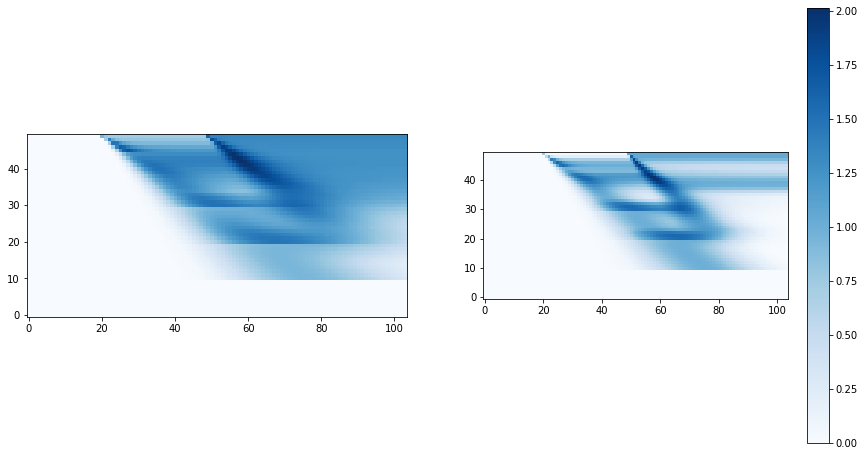

In [28]:
fig, axs = plt.subplots(1,2, figsize = (15,8))
axs[0].imshow(hr.transpose(), origin = 'lower',
           interpolation = 'none', cmap = 'Blues')
axs[1].imshow(h.transpose(), origin = 'lower',
           interpolation = 'none', cmap = 'Blues')

ax=plt.gca() #get the current axes
for PCM in ax.get_children():
    if isinstance(PCM, plt.cm.ScalarMappable):
        break
        
plt.colorbar(PCM, ax=ax)
plt.savefig(f'..figures/{model}_entropy.svg', format = 'svg')
plt.show()

#### Analyzing prior versus posterior parameter distributions

In [ ]:
# load this if you ran the MCMC on this kernel
accP = np.asarray(accepted_params)
rejP = np.asarray(rejected_params)

In [35]:
# or Loading the parameters from a previous run
accP = np.load('../data/PlanarModel_AcceptedParams.npy')
rejP = np.load('../data/PlanarModel_RejectedParams.npy')

In [37]:
print(len(accP) + len(rejP)) #total number of runs

26551


In [41]:
#posterior means and stds
print(accP[:,0,1].mean(), accP[:,0,2].mean(), accP[:,1,1].mean(), accP[:,1,2].mean())
print(accP[:,0,1].std(), accP[:,0,2].std(), accP[:,1,1].std(), accP[:,1,2].std())

-1833.079151601799 35.414997449383094 -2923.958692102559 41.576618799197654
388.0840385216854 7.2283759273502035 428.8193196322985 6.715993920538768


In [45]:
prior_means = [[-1500,45,-2000,25],
              [-1800,35,-2500,35],
              [-2000,35,-3000,35]]

prior_stds = [[500,8,500,8]]

post_means = [[-1625.0254029078897, 45.30249753338708, -2761.783209911276, 38.05784733193563],
[-1833.079151601799, 35.414997449383094, -2923.958692102559, 41.576618799197654],
[-1897.7707340100046, 33.57334071245642, -3256.171849419064, 40.05477460622264]]

post_stds = [[308.6603758916101, 7.621850841343381, 391.34114442254685, 6.127213039754968],
       [388.0840385216854, 7.2283759273502035, 428.8193196322985, 6.715993920538768],
       [413.47837674385875, 7.231898814573313, 455.9191787298203, 7.108650904486277]]

In [46]:
import seaborn as sns
from scipy.stats import norm
from scipy.stats import norm, gaussian_kde

def prior_vs_posterior(accepted, run):
    prior_mean = prior_means[run][0]
    prior_std = prior_stds[0][0]
    prior_mean2 = prior_means[run][1]
    prior_std2 = prior_stds[0][1]
    prior_mean3 = prior_means[run][2]
    prior_std3 = prior_stds[0][0]
    prior_mean4 = prior_means[run][3]
    prior_std4 = prior_stds[0][1]
    
    fig, ax = plt.subplots(2,2, figsize = (8,5))
    
    x = np.linspace(prior_mean - 3 * prior_std, prior_mean + 3 * prior_std)
    y = 1 / (prior_std * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - prior_mean) / prior_std) ** 2)
    ax[0,0].plot(x,y, color = 'lightcoral', alpha = 0.8)
    ax[0,0].fill_between(x,y,alpha = 0.3, color = 'lightcoral', label = 'prior')
    ax[0,0].set_title('Fault 1: Slip [m]')
    ax[0,0].set_ylabel('Density')
    
    ax[1,0].set_ylabel('Density')
    
    hist, bins, _ = ax[0,0].hist(accepted[:,0,1], bins = 30, density = True, color = 'steelblue', alpha = 0.5, label = 'posterior')
    
    x2 = np.linspace(prior_mean2 - 3 * prior_std2, prior_mean2 + 3 * prior_std2)
    y2 = 1 / (prior_std2 * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x2 - prior_mean2) / prior_std2) ** 2)
    ax[0,1].plot(x2,y2, color = 'lightcoral', alpha = 0.8)
    ax[0,1].fill_between(x2,y2,alpha = 0.3, color = 'lightcoral')
    ax[0,0].legend()
    
    hist2, bins2, _ = ax[0,1].hist(accepted[:,0,2], bins = 30, density = True,  color = 'steelblue', alpha = 0.5)
    ax[0,1].set_title('Fault 1: Dip')
    
    x3 = np.linspace(prior_mean3 - 3 * prior_std3, prior_mean3 + 3 * prior_std3)
    y3 = 1 / (prior_std3 * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x3 - prior_mean3) / prior_std3) ** 2)
    ax[1,0].plot(x3,y3, color = 'lightcoral', alpha = 0.8)
    ax[1,0].fill_between(x3,y3,alpha = 0.3, color = 'lightcoral')
    
    hist3, bins3, _ = ax[1,0].hist(accepted[:,1,1], bins = 30, density = True, color = 'steelblue', alpha = 0.5)
    ax[1,0].set_title('Fault 2: Slip [m]')
    
    x4 = np.linspace(prior_mean4 - 3 * prior_std4, prior_mean4 + 3 * prior_std4)
    y4 = 1 / (prior_std4 * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x4 - prior_mean4) / prior_std4) ** 2)
    ax[1,1].plot(x4,y4, color = 'lightcoral', alpha = 0.8)
    ax[1,1].fill_between(x4,y4,alpha = 0.3, color = 'lightcoral')
    
    hist4, bins4, _ = ax[1,1].hist(accepted[:,1,2], bins = 30, density = True, color = 'steelblue', alpha = 0.5)
    ax[1,1].set_title('Fault 2: Dip')
    
    plt.tight_layout()
    #plt.savefig(f'..figures/{model}_priorpostcurves.svg')
    plt.show()
    

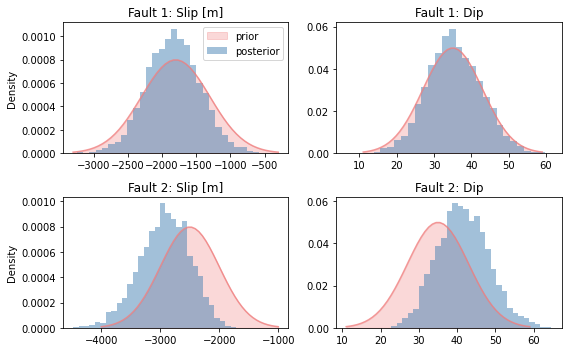

In [47]:
prior_vs_posterior(accP, run = 1)

#### Analyzing prior versus posterior exhumation

In [48]:
#first need to extract exhumation from data
def exhumation_std(array):
    
    exh_b1 = []
    exh_b2 = []
    n_draws = len(array)
    
    for i in range(n_draws):
        exhumation = [abs(np.sin(np.deg2rad(array[:,0,2][i])) * (array[:,0,1][i])), 
                      abs(np.sin(np.deg2rad(array[:,1,2][i])) *(array[:,1,1][i]))]
       
        exh_b1.append(-exhumation[0])
        exh_b2.append(-exhumation[0] - exhumation[1])
    
    mean_b1 = np.mean(exh_b1)
    mean_b2 = np.mean(exh_b2)
    std_b1 = np.std(exh_b1)
    std_b2 = np.std(exh_b2)
    
    return mean_b1, mean_b2, std_b1, std_b2, exh_b1, exh_b2

In [49]:
mean_b1, mean_b2, std_b1, std_b2, exh_b1, exh_b2 = exhumation_std(accP)
mean_b1, mean_b2, std_b1, std_b2, exh_b1r, exh_b2r = exhumation_std(rejP)

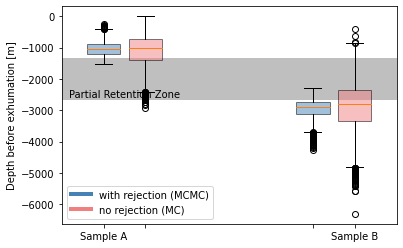

In [50]:
exh = [exh_b1,exh_b1r, exh_b2, exh_b2r]
fig, ax = plt.subplots()
width = 0.4
positions = [1,1.5,3.5,4]

for i in range(len(exh)):
    if i % 2 == 0:
        color = 'steelblue'
        label = 'accepted'
    else:
        color = 'lightcoral'
        label = 'rejected'
        
    box = ax.boxplot(exh[i], positions = [positions[i]], widths = width, patch_artist = True, boxprops=dict(facecolor=color))
    box['boxes'][0].set_alpha(0.5)

ax.axhspan(-2666, -1333, facecolor='grey', alpha=0.5)
ax.text(1.25, -2500, 'Partial Retention Zone', ha = 'center', va = 'center')
ax.set_ylabel('Depth before exhumation [m]')
ax.set_xticks(positions)
ax.set_xticklabels(['Sample A', ' ', ' ', 'Sample B'])

legend_elements = [
    plt.Line2D([0], [0], color='steelblue', lw=4, label='with rejection (MCMC)'),
    plt.Line2D([0], [0], color='lightcoral', lw=4, label='no rejection (MC)')
]
ax.legend(handles=legend_elements, loc='lower left')
plt.savefig(f'..figures/{model}_boxplots.svg')

#### Parameter correlation

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


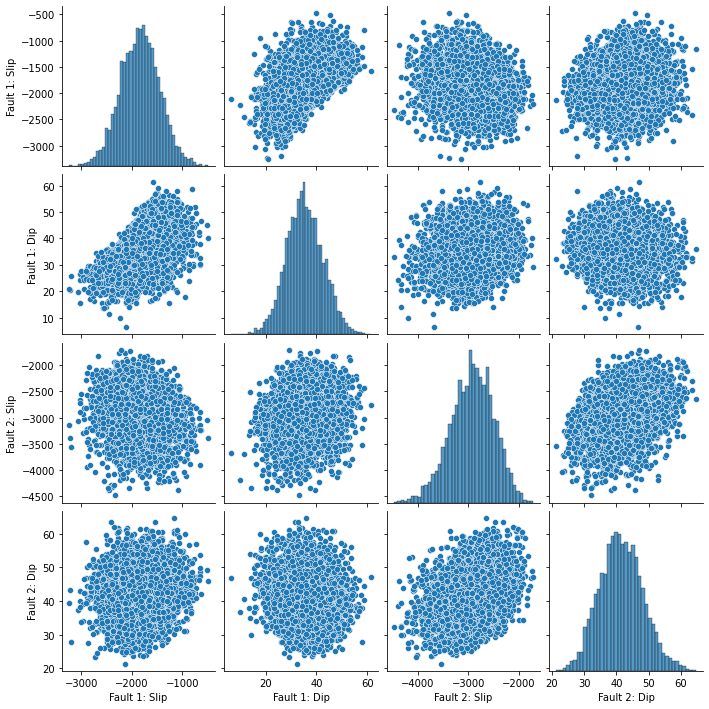

In [54]:
all_post = np.array([accP[:,0,1], accP[:,0,2], accP[:,1,1], accP[:,1,2]])
df = pd.DataFrame(all_post.transpose(), columns = ['Fault 1: Slip', 'Fault 1: Dip', 'Fault 2: Slip', 'Fault 2: Dip'])
import seaborn as sns
sns.pairplot(df)

Let's focus on those that really changed:

In [51]:
def data_to_df(accepted, rejected):
    acc_df = pd.DataFrame(columns = ['Fault 1: Slip', 'Fault 1: Dip', 'Fault 2: Slip', 'Fault 2: Dip'])
    acc_df['Fault 1: Slip'] = accepted[:,0,1]
    acc_df['Fault 1: Dip'] = accepted[:,0,2]
    acc_df['Fault 2: Slip'] = accepted[:,1,1]
    acc_df['Fault 2: Dip'] = accepted[:,1,2]
    
    rej_df = pd.DataFrame(columns = ['Fault 1: Slip', 'Fault 1: Dip', 'Fault 2: Slip', 'Fault 2: Dip'])
    rej_df['Fault 1: Slip'] = rejected[:,0,1]
    rej_df['Fault 1: Dip'] = rejected[:,0,2]
    rej_df['Fault 2: Slip'] = rejected[:,1,1]
    rej_df['Fault 2: Dip'] = rejected[:,1,2]
    return acc_df,rej_df

In [52]:
acc_df,rej_df = data_to_df(accP, rejP)

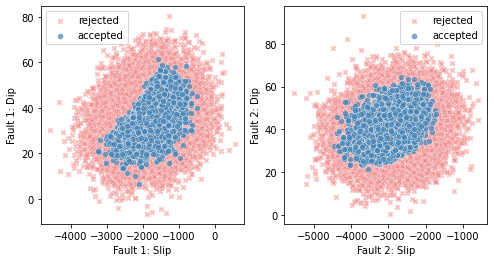

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

sns.scatterplot(x='Fault 1: Slip', y='Fault 1: Dip', data=rej_df, ax=ax[0], color='lightcoral', alpha=0.5, marker='X', label='rejected')
sns.scatterplot(x='Fault 1: Slip', y='Fault 1: Dip', data=acc_df, ax=ax[0], color='steelblue', alpha=0.7, label='accepted')
sns.scatterplot(x='Fault 2: Slip', y='Fault 2: Dip', data=rej_df, ax=ax[1], color='lightcoral', alpha=0.5, marker='X', label='rejected')
sns.scatterplot(x='Fault 2: Slip', y='Fault 2: Dip', data=acc_df, ax=ax[1], color='steelblue', alpha=0.7, label='accepted')

plt.savefig(f'../figures/{model}_correlation.png')
plt.show()

#### Convergence

Text(0.5, 1.0, 'Fault 2: Dip')

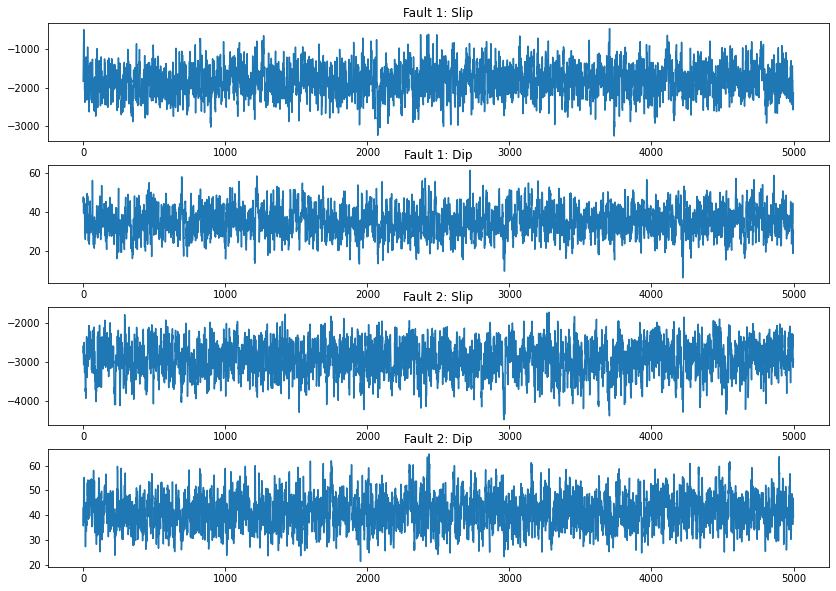

In [40]:
#trace plots
fig, ax = plt.subplots(4,1, figsize = (14,10))
ax[0].plot(accP[:,0,1], label = 'accepted')
ax[0].set_title("Fault 1: Slip")
ax[1].plot(accP[:,0,2])
ax[1].set_title("Fault 1: Dip")
ax[2].plot(accP[:,1,1])
ax[2].set_title("Fault 2: Slip")
ax[3].plot(accP[:,1,2])
ax[3].set_title("Fault 2: Dip")

In [21]:
# geweke test for convergence
def geweke(samples, segment_length, parameter, rm_burn_in = True):
    
    if rm_burn_in == True:
        burn_in = int(len(samples) * 0.2) #burn-in considered as the first 2 percent of the accepted samples.
        samples = samples[burn_in:] #remove the first 2 percent of the samples.
    
    num_segments = len(samples) // segment_length
    
    if parameter in [1]:
        params = samples[:,0,1]
    elif parameter in [2]:
        params = samples[:,0,2]
    elif parameter in [3]:
        params = samples[:,1,1]
    else:
        params = samples[:,1,2]
    
    z_scores = []
    for i in range(num_segments):
        start_index = i * segment_length
        end_index = (i + 1) * segment_length
        
        mean_first = np.mean(params[:segment_length])
        mean_last = np.mean(params[start_index:end_index])
        
        var_first = np.var(params[:segment_length])
        var_last = np.var(params[start_index:end_index])
        
        z_score = (mean_first - mean_last) / np.sqrt(var_first / segment_length + var_last / segment_length)
        z_scores.append(z_score)
    return z_scores

Text(0.1, 0.5, 'Z-scores')

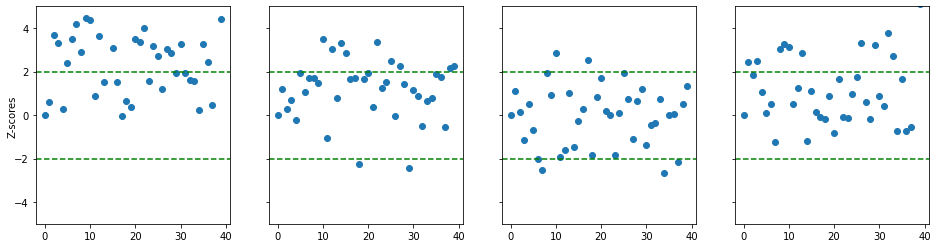

In [22]:
seg_length = 100
n_draws = 5000
fig, axs = plt.subplots(1,4, figsize = (16,4), sharey = True)

for i, ax in enumerate(axs):
    z_score = geweke(accP, seg_length, i+1)
    segments = np.arange((n_draws - (n_draws*0.2))/seg_length)
    ax.scatter(segments,z_score)
    ax.set_ylim(-5,5)
    ax.axhline(y = 2, color = 'green', linestyle = '--')
    ax.axhline(y = -2, color = 'green', linestyle = '--')
fig.text(0.1, 0.5, 'Z-scores', va='center', rotation='vertical')

In [23]:
def autocorrelation_plot(samples, max_lag, parameter, rm_burn_in):
    
    if rm_burn_in == True:
        burn_in = int(len(samples) * 0.2) #burn-in considered as the first 2 percent of the accepted samples.
        samples = samples[burn_in:] #remove the first 2 percent of the samples.
    
    if parameter in [1]:
        params = samples[:,0,1]
    elif parameter in [2]:
        params = samples[:,0,2]
    elif parameter in [3]:
        params = samples[:,1,1]
    else:
        params = samples[:,1,2]
    
    autocorr_values = []
    for lag in range(max_lag+1):
        autocorr = np.corrcoef(params[:-(lag+1)], params[(lag+1):])[0,1]
        autocorr_values.append(autocorr)
        
    plt.stem(range(max_lag+1), autocorr_values, use_line_collection=True)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.title('Autocorrelation Plot')
    plt.show()

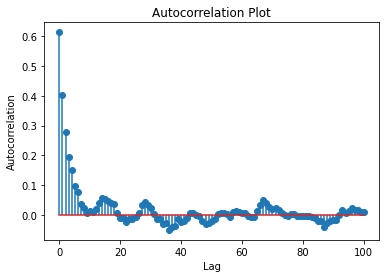

In [24]:
autocorrelation_plot(accP, 100, 4, rm_burn_in =True)